# DLOps Project

## Audio Classification using urbansound_8k dataset

    Ayush Abrol B20AI052
    Neehal Prakash Bajaj B20AI026
    Aryan Tiwari B20AI056

---

### Necessary Imports

In [43]:
import torch
import torchvision
from torchvision.datasets.utils import download_url
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
import librosa.display
import tarfile
import torch.nn as nn
import torch.nn.functional as F

In [44]:
project = "urbansound8kclassification"

### Loading the metadata

In [45]:
df=pd.read_csv("data/UrbanSound8K.csv")
df
classes=list(df["class"].unique())
classes

['dog_bark',
 'children_playing',
 'car_horn',
 'air_conditioner',
 'street_music',
 'gun_shot',
 'siren',
 'engine_idling',
 'jackhammer',
 'drilling']

### Taking a single file from each class to display waveplots

In [46]:
paths=dict()
for i in range(len(classes)):
    temp_df=df[df["class"]==classes[i]].reset_index()
    fold=temp_df["fold"].iloc[0]    # The fold of the first audio sample for the specific class
    sample_name=temp_df["slice_file_name"].iloc[0]
    path="data/fold{0}/{1}".format(fold, sample_name)
    paths[classes[i]]=path
paths

{'dog_bark': 'data/fold5/100032-3-0-0.wav',
 'children_playing': 'data/fold5/100263-2-0-117.wav',
 'car_horn': 'data/fold10/100648-1-0-0.wav',
 'air_conditioner': 'data/fold5/100852-0-0-0.wav',
 'street_music': 'data/fold7/101848-9-0-0.wav',
 'gun_shot': 'data/fold1/102305-6-0-0.wav',
 'siren': 'data/fold7/102853-8-0-0.wav',
 'engine_idling': 'data/fold10/102857-5-0-0.wav',
 'jackhammer': 'data/fold1/103074-7-0-0.wav',
 'drilling': 'data/fold3/103199-4-0-0.wav'}

### Plotting amplitudes of different classes

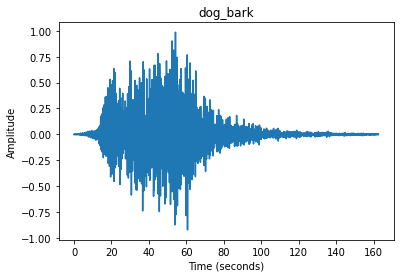

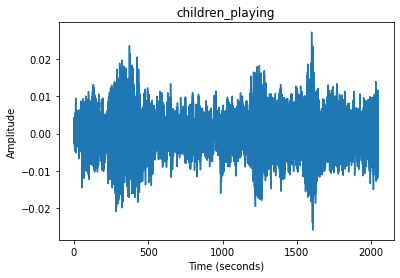

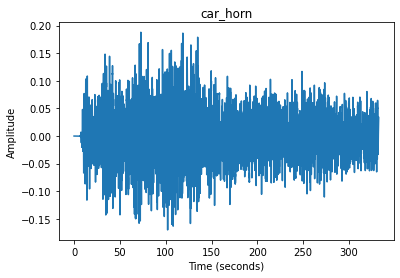

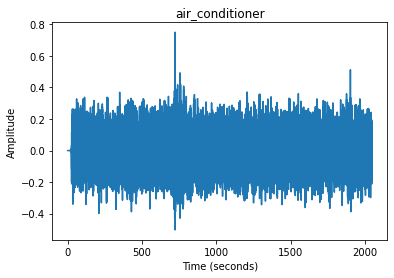

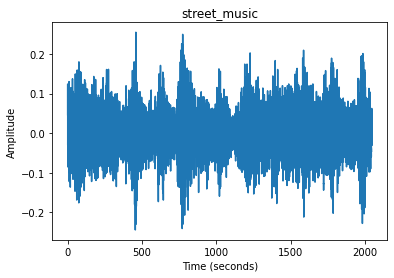

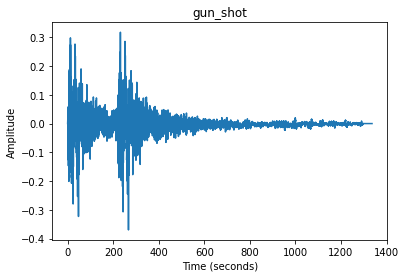

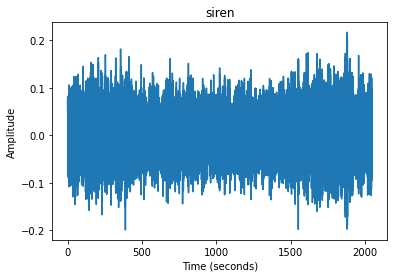

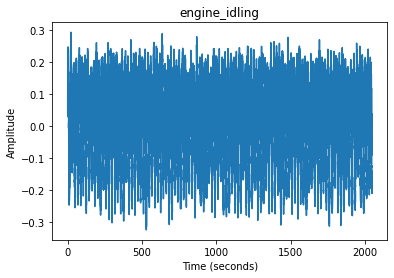

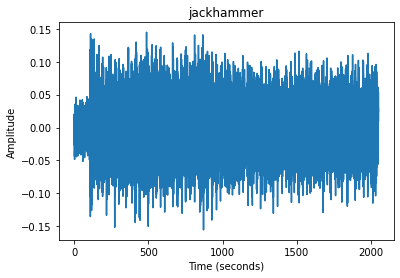

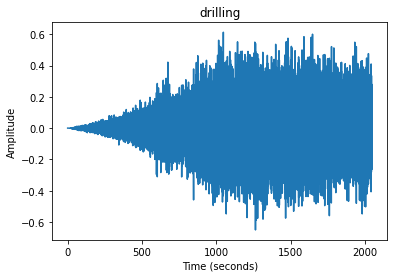

In [47]:
for i, label in enumerate(classes):
    sample=paths[label]
    plt.clf()
    plt.title(label)
    data, sample_rate=librosa.load(sample)
     
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.plot(librosa.times_like(data), data)
    plt.show()

### For audio samples, one of the main features involved is the power spectrum. One type of power specturm is called the Mel Frequency Cepstrum.We calculate the coefficients for Mel Frequency Cepstrum (MFCC) using librosa. Lets extract the MFCCs for a single audio sample as an example

In [48]:
# We can decide how many mfccs are required for each sample. Here we chose 40 coefficients.
path=paths["drilling"]
audio, sr = librosa.load(path)
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
mfccs.shape

(40, 173)

### To use a vector of features for each audio sample, we take the mean of the mffcs for each frame of the sample.

In [49]:
# Helper function to generate mfccs
def extract_mfcc(path):
    audio, sr=librosa.load(path)
    mfccs=librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    return np.mean(mfccs.T, axis=0)

### Converting all the audio samples into numeric data

In [50]:
features=[]
labels=[]
folds=[]
for i in range(len(df)):
    fold=df["fold"].iloc[i]
    filename=df["slice_file_name"].iloc[i]
    path="data/fold{0}/{1}".format(fold, filename)
    mfccs=extract_mfcc(path)

    # dataset.append((mfccs,df["classID"].iloc[i]))
    features.append(mfccs)
    folds.append(fold)
    labels.append(df["classID"].iloc[i])

c:\Users\Ayush Abrol\AppData\Local\Programs\Python\Python37\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
c:\Users\Ayush Abrol\AppData\Local\Programs\Python\Python37\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
c:\Users\Ayush Abrol\AppData\Local\Programs\Python\Python37\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"


### Converting the features and labels to a tensor dataset

In [53]:
features=torch.tensor(features)
features
labels=torch.tensor(labels)
labels
folds=torch.tensor(folds)
folds
# Saving the dataset to disk to prevent re-Loading
torch.save(features, "data/features_mfccs.pt")
torch.save(labels, "data/labels.pt")
torch.save(folds, "data/folds.pt")

c:\Users\Ayush Abrol\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
c:\Users\Ayush Abrol\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\Ayush Abrol\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

### Execute the following code to load the dataset from disk and store the values in tensors

In [54]:
features=torch.load("data/features_mfccs.pt")
labels=torch.load("data/labels.pt")
folds=torch.load("data/folds.pt")

### The makers of this dataset have clearly mentioned instructions to split the data into training and test sets. We shall train this model appropriately.

In [55]:
def get_dataset(skip_fold):
    local_features=[]
    local_labels=[]
    for i in range(len(folds)):
        if folds[i]==skip_fold:
            continue
        local_features.append(features[i])
        local_labels.append(labels[i])
    local_features=torch.stack(local_features)
    local_labels=torch.stack(local_labels)
    return TensorDataset(local_features, local_labels)

### Initializing the dataset

In [56]:
dataset=get_dataset(skip_fold=10)
len(dataset)

7895

### Let's split the training data into training and validation data

In [57]:
val_size=int(0.1*len(dataset))
train_size=len(dataset)-val_size

train_ds, val_ds=random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(7106, 789)

### Initializing the data loader

In [58]:
batch_size=128
train_loader=DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader=DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

# Looking at a batch of data
for x,y in train_loader:
    print(f"feautres: {x}\nlabels: {y}")
    print(f"dtypes: (x)->{x.dtype}, (y)->{y.dtype}")
    break

feautres: tensor([[-129.1760,   77.7270,    9.5845,  ...,    2.5948,   -0.7297,
            3.0579],
        [-106.3070,  -18.2969,  -56.1411,  ...,    1.6643,   -0.7789,
           -4.0838],
        [-214.9511,  132.5433,  -50.2950,  ...,   -0.5648,   -2.7552,
            0.9196],
        ...,
        [-133.7408,   -4.0873,  -24.4263,  ...,    0.5144,    7.5047,
            3.2041],
        [  -7.4996,  -22.8779,  -27.9464,  ...,    0.2322,   -2.0395,
           -1.8343],
        [-231.4249,  171.2546,  -11.9667,  ...,    2.8576,   -3.3131,
            1.1153]])
labels: tensor([0, 4, 2, 5, 4, 9, 5, 8, 8, 2, 7, 6, 9, 7, 4, 0, 8, 0, 0, 4, 3, 3, 1, 7,
        9, 8, 8, 2, 7, 7, 8, 1, 2, 1, 5, 5, 9, 7, 8, 9, 4, 3, 9, 0, 4, 5, 0, 4,
        7, 3, 7, 5, 2, 0, 5, 4, 9, 0, 2, 3, 0, 7, 1, 9, 4, 7, 0, 5, 9, 3, 2, 5,
        4, 8, 8, 2, 3, 8, 4, 6, 7, 7, 2, 2, 9, 2, 5, 9, 9, 5, 2, 9, 6, 9, 5, 9,
        5, 9, 7, 6, 2, 0, 4, 5, 9, 7, 4, 2, 2, 3, 3, 0, 7, 0, 8, 7, 7, 8, 0, 3,
        7, 0, 8, 4, 7,

### Defining a function that calculates the accuracy of predictions

In [59]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Defining a function to get the default device, i.e, CPU or GPU

In [60]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

device=get_default_device()
device

device(type='cuda')

#### Defining the model

In [61]:
class AudioClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        # images, labels = images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        # images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


### Defining the models

In [62]:
input_size=40   # Since we're generating 40 mfccs, the number of input features is 40
output_size=10
class UrbanSound8KModel(AudioClassificationBase):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Linear(input_size,128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64,output_size),
            nn.Sigmoid()
        )

    def forward(self, x_batch):
        return self.network(x_batch)

class UrbanSound8KModel2(AudioClassificationBase):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Linear(input_size,128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.ReLU(),

            nn.Linear(256, 512),
            nn.ReLU(),

            nn.Linear(512,64),
            nn.ReLU(),

            nn.Linear(64,output_size),
            nn.Tanh()
        )

    def forward(self, xb):
        return self.network(xb)


### Defining functions to plot losses and accuracies over time

In [63]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x', label='loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.title('Loss vs. No. of epochs')

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x', label='accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy vs. No. of epochs')

### Function to move data to the chosen default device

In [64]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Defining an instance that moves all the tensors (DataLoaders) into the default device
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

# Moving the data to the device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

### Training and evaluation

In [66]:
def evaluate(model, val_loader):
    model.eval()
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def train(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, print_loss=True):
    torch.cuda.empty_cache()
    history=[]
    optimizer=opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_accs = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_accs.append(model.validation_step(batch)['val_acc'])
        
        print(f"Epoch [{epoch}]: Training loss -> {torch.stack(train_losses).mean().item()}")   
        print(f"Epoch [{epoch}]: Training accuracy -> {torch.stack(train_accs).mean().item()}")
        # Validation phase
        with torch.no_grad():
            result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        # model.epoch_end(epoch, result)
        history.append(result)
        if print_loss:
            print(f"Epoch [{epoch}]: Validation loss -> {result['val_loss']}, Validation accuracy -> {result['val_acc']}")
    return history

Initializing the model and moving it to the GPU

In [67]:
model=UrbanSound8KModel()
model
# Moving the model to the GPU
to_device(model, device)

model2=UrbanSound8KModel2()
to_device(model2, device)

UrbanSound8KModel2(
  (network): Sequential(
    (0): Linear(in_features=40, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=10, bias=True)
    (9): Tanh()
  )
)

In [68]:
model

UrbanSound8KModel(
  (network): Sequential(
    (0): Linear(in_features=40, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): Sigmoid()
  )
)

In [69]:
history=[evaluate(model, val_loader)]
history
history2=[evaluate(model2, val_loader)]
history2

[{'val_loss': 2.3408398628234863, 'val_acc': 0.1273384392261505}]

Begin training the model. Feel free to change the number of epochs and the learning rate.

In [70]:
epochs=40
lr=0.01
history+=train(epochs, lr, model, train_loader, val_loader)

Epoch [0]: Training loss -> 2.2064931392669678
Epoch [0]: Training accuracy -> 0.25411340594291687
Epoch [0]: Validation loss -> 2.190535306930542, Validation accuracy -> 0.22486183047294617
Epoch [1]: Training loss -> 2.1339333057403564
Epoch [1]: Training accuracy -> 0.32909733057022095
Epoch [1]: Validation loss -> 2.139526844024658, Validation accuracy -> 0.3209502398967743
Epoch [2]: Training loss -> 2.1028456687927246
Epoch [2]: Training accuracy -> 0.35267433524131775
Epoch [2]: Validation loss -> 2.1085546016693115, Validation accuracy -> 0.3457164168357849
Epoch [3]: Training loss -> 2.0858287811279297
Epoch [3]: Training accuracy -> 0.38020411133766174
Epoch [3]: Validation loss -> 2.092938184738159, Validation accuracy -> 0.3523065745830536
Epoch [4]: Training loss -> 2.0707056522369385
Epoch [4]: Training accuracy -> 0.3937702775001526
Epoch [4]: Validation loss -> 2.0836057662963867, Validation accuracy -> 0.3421556055545807
Epoch [5]: Training loss -> 2.0594921112060547
E

In [ ]:
torch.save(model.state_dict(), './models/model.pth')

In [71]:
history

[{'val_loss': 2.359490394592285, 'val_acc': 0.15646257996559143},
 {'val_loss': 2.190535306930542,
  'val_acc': 0.22486183047294617,
  'train_loss': 2.2064931392669678,
  'lrs': []},
 {'val_loss': 2.139526844024658,
  'val_acc': 0.3209502398967743,
  'train_loss': 2.1339333057403564,
  'lrs': []},
 {'val_loss': 2.1085546016693115,
  'val_acc': 0.3457164168357849,
  'train_loss': 2.1028456687927246,
  'lrs': []},
 {'val_loss': 2.092938184738159,
  'val_acc': 0.3523065745830536,
  'train_loss': 2.0858287811279297,
  'lrs': []},
 {'val_loss': 2.0836057662963867,
  'val_acc': 0.3421556055545807,
  'train_loss': 2.0707056522369385,
  'lrs': []},
 {'val_loss': 2.0830330848693848,
  'val_acc': 0.3524128496646881,
  'train_loss': 2.0594921112060547,
  'lrs': []},
 {'val_loss': 2.0786993503570557,
  'val_acc': 0.32754039764404297,
  'train_loss': 2.051133871078491,
  'lrs': []},
 {'val_loss': 2.070875883102417,
  'val_acc': 0.3544323742389679,
  'train_loss': 2.045637369155884,
  'lrs': []},
 {

In [72]:
epochs=40
lr=0.01
history2+=train(epochs, lr, model2, train_loader, val_loader)

Epoch [0]: Training loss -> 2.1147289276123047
Epoch [0]: Training accuracy -> 0.27690407633781433
Epoch [0]: Validation loss -> 2.0458340644836426, Validation accuracy -> 0.2672725319862366
Epoch [1]: Training loss -> 1.9562960863113403
Epoch [1]: Training accuracy -> 0.35648757219314575
Epoch [1]: Validation loss -> 1.8934441804885864, Validation accuracy -> 0.37484055757522583
Epoch [2]: Training loss -> 1.8705759048461914
Epoch [2]: Training accuracy -> 0.42318132519721985
Epoch [2]: Validation loss -> 1.8578965663909912, Validation accuracy -> 0.42038694024086
Epoch [3]: Training loss -> 1.8051320314407349
Epoch [3]: Training accuracy -> 0.4636135399341583
Epoch [3]: Validation loss -> 1.8104578256607056, Validation accuracy -> 0.41501912474632263
Epoch [4]: Training loss -> 1.754880666732788
Epoch [4]: Training accuracy -> 0.4702211916446686
Epoch [4]: Validation loss -> 1.7575592994689941, Validation accuracy -> 0.4482887089252472
Epoch [5]: Training loss -> 1.717848300933838
Ep

In [73]:
history2

[{'val_loss': 2.3408398628234863, 'val_acc': 0.1273384392261505},
 {'val_loss': 2.0458340644836426,
  'val_acc': 0.2672725319862366,
  'train_loss': 2.1147289276123047,
  'lrs': []},
 {'val_loss': 1.8934441804885864,
  'val_acc': 0.37484055757522583,
  'train_loss': 1.9562960863113403,
  'lrs': []},
 {'val_loss': 1.8578965663909912,
  'val_acc': 0.42038694024086,
  'train_loss': 1.8705759048461914,
  'lrs': []},
 {'val_loss': 1.8104578256607056,
  'val_acc': 0.41501912474632263,
  'train_loss': 1.8051320314407349,
  'lrs': []},
 {'val_loss': 1.7575592994689941,
  'val_acc': 0.4482887089252472,
  'train_loss': 1.754880666732788,
  'lrs': []},
 {'val_loss': 1.8005682229995728,
  'val_acc': 0.4194834232330322,
  'train_loss': 1.717848300933838,
  'lrs': []},
 {'val_loss': 1.7751506567001343,
  'val_acc': 0.40678146481513977,
  'train_loss': 1.681199550628662,
  'lrs': []},
 {'val_loss': 1.6606053113937378,
  'val_acc': 0.49883079528808594,
  'train_loss': 1.653255820274353,
  'lrs': []},


In [75]:
# Save model using torch
torch.save(model.state_dict(), './models/model.pth')
torch.save(model2.state_dict(), './models/model2.pth')

In [ ]:
# Also save the model using pickle
pickle.dump(model, open('./models/model.pkl', 'wb'))
pickle.dump(model2, open('./models/model2.pkl', 'wb'))

### Finally let's plot the accuracies and losses over time

For model 1


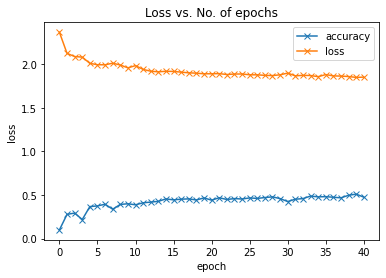

In [36]:
print("For model 1")
plot_accuracies(history)
plot_losses(history)

For model 2


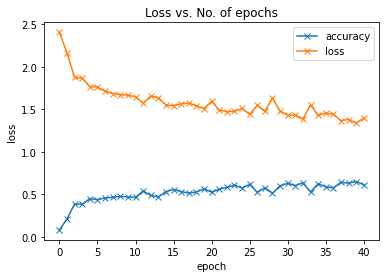

In [35]:
print("For model 2")
plot_accuracies(history2)
plot_losses(history2)

**END OF PROJECT**